In [1]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import PIL.Image
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

img_size = (256,256)

# Load the pre-trained VGG19 model
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
model.trainable = False

# Print the summary of the model VGG19 model needed to train the feed forward neural style transfer model
model.summary()

Mounted at /content/drive
Found GPU at: /device:GPU:0
80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
        

In [2]:
# helper functions
def image_to_tensor(image, expand = True):
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.resize(image, img_size)
  image /= 255
  if expand == True:
    image =  tf.expand_dims(image, axis = 0)
  return image

def tensor_to_image(tensor, squeeze = True):
  if squeeze == True:
    tensor = tf.squeeze(tensor, axis=0)
  tensor = tf.multiply(tensor,255)
  tensor = np.array(tensor, dtype=np.uint8)
  return PIL.Image.fromarray(tensor)

6


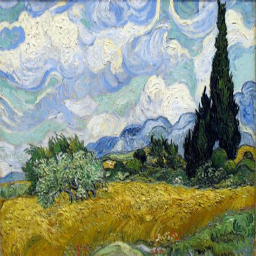

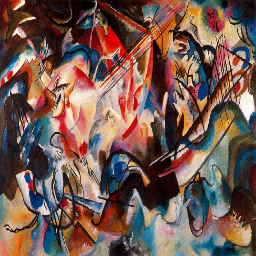

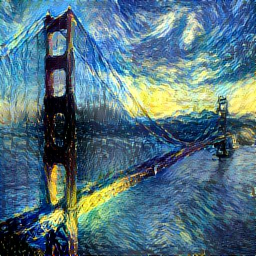

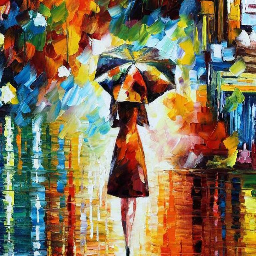

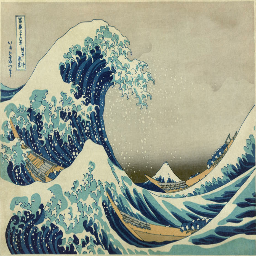

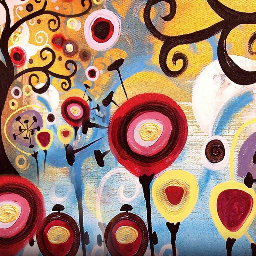

In [136]:
# loads the style images and put them in a list
# only use 3 styles for now

style_image_1 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/vgogh.jpeg'), expand = False)
style_image_2 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/kandinsky.jpg'), expand = False)
style_image_3 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/vgogh2.jpeg'), expand = False)
style_image_4 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/rain-princess-cropped.jpeg'), expand = False)
style_image_5 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/wave.jpeg'), expand = False)
style_image_6 = image_to_tensor(tf.io.read_file('/content/drive/MyDrive/Colab_Notebooks/candy.jpeg'), expand = False)



styles = [style_image_1, style_image_2, style_image_3, style_image_4, style_image_5, style_image_6]
num_styles = len(styles)
print(num_styles)
for style in styles:
  display.display(tensor_to_image(style, squeeze = False))
  print(' ')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteN7C7NO/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteN7C7NO/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
3680
examples:


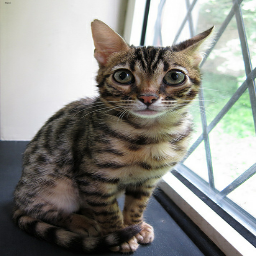

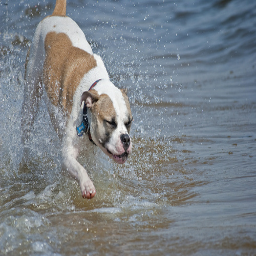

In [4]:
import tensorflow_datasets as tfds

# Load the dataset
# we are training on weird animal pictures woehoe

dataset = tfds.load('oxford_iiit_pet', split='train[:100%]', shuffle_files=True)

train_dataset = []
for data in dataset:
    # Get the images
    data = data['image']/255
    train_dataset.append(tf.image.resize(data, img_size))

num_images = len(train_dataset)
print(num_images)
print('examples:')
display.display(tensor_to_image(train_dataset[3], squeeze = False))
print(' ')
display.display(tensor_to_image(train_dataset[20], squeeze = False))

In [5]:
# feed forward model with multiple styles
class instance_norm_2D(tf.keras.Model):
  def __init__(self, channels):
    super(instance_norm_2D, self).__init__()

    self.epsilon = 1e-5
    self.scale = tf.Variable(tf.ones((1, 1, 1, channels)))
    self.shift = tf.Variable(tf.zeros((1, 1, 1, channels)))

  def call(self, x, alpha = None):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    x_norm = tf.nn.batch_normalization(x, mean, variance, offset=None, scale=None, variance_epsilon=self.epsilon)

    if alpha == None:
      out = x_norm * self.scale + self.shift
    else:
      out = x_norm * (alpha*self.scale) + (alpha*self.shift)

    return out


class batch_InstanceNorm2d(tf.keras.Model):
  def __init__(self, num_styles, in_channels):
    super(batch_InstanceNorm2d, self).__init__()

    self.inns = [instance_norm_2D(in_channels) for i in range(num_styles)]

  def call(self, x, style_ids, alpha = None, style_ids_2 = None):

   if alpha == None:
    out = tf.stack([ tf.squeeze(self.inns[style_ids[i]](tf.expand_dims(x[i], axis=0))) for i in range(len(style_ids))])
   else:
    out_1 = tf.stack([ tf.squeeze(self.inns[style_ids[i]](tf.expand_dims(x[i], axis=0), alpha)) for i in range(len(style_ids))])
    out_2 = tf.stack([ tf.squeeze(self.inns[style_ids_2[i]](tf.expand_dims(x[i], axis=0), (1-alpha))) for i in range(len(style_ids))])
    out = out_1+out_2

   return out


class ConvLayer(tf.keras.Model):
  def __init__(self, out_channels, kernel_size, strides):
    super(ConvLayer, self).__init__()

    self.padding_size =  kernel_size // 2
    self.paddings = tf.constant([[0, 0], [self.padding_size, self.padding_size], [self.padding_size, self.padding_size], [0, 0]])

    self.Conv2D = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=kernel_size, strides=strides, padding='valid', activation=None)

  def call(self, x):
    padded = tf.pad(x, self.paddings, "REFLECT")
    out = self.Conv2D(padded)
    return out


class ResidualBlock(tf.keras.Model):
  def __init__(self, out_channels):
    super(ResidualBlock, self).__init__()

    self.epsilon = 1e-5
    self.Conv1 = ConvLayer(out_channels, kernel_size=3, strides=1)
    self.Conv2 = ConvLayer(out_channels, kernel_size=3, strides=1)

  def call(self, x):
    residual = x

    out = self.Conv1(x)
    mean, variance = tf.nn.moments(out, axes=[1, 2], keepdims=True)
    out = tf.nn.batch_normalization(out, mean, variance, offset=None, scale=None, variance_epsilon=self.epsilon)
    out = tf.nn.relu(out)

    out = self.Conv2(out)
    mean, variance = tf.nn.moments(out, axes=[1, 2], keepdims=True)
    out = tf.nn.batch_normalization(out, mean, variance, offset=None, scale=None, variance_epsilon=self.epsilon)

    return out + residual


class UpsampleConvLayer(tf.keras.Model):
  def __init__(self, out_channels, kernel_size, strides, upsample):
    super(UpsampleConvLayer, self).__init__()

    self.Conv = ConvLayer(out_channels, kernel_size=kernel_size, strides=strides)

  def call(self, x):
    out = tf.image.resize(x, size=(2 * tf.shape(x)[1], 2 * tf.shape(x)[2]), method='nearest')
    out = self.Conv(out)
    return out


class TransformerNet(tf.keras.Model):
  def __init__(self, style_num):
    super(TransformerNet, self).__init__()

    self.conv1 = ConvLayer(32, kernel_size = 9, strides = 1)
    self.in1 = batch_InstanceNorm2d(style_num, 32)

    self.conv2 = ConvLayer(64, kernel_size = 3, strides = 2)
    self.in2 = batch_InstanceNorm2d(style_num, 64)

    self.conv3 = ConvLayer(128, kernel_size = 3, strides = 2)
    self.in3 = batch_InstanceNorm2d(style_num, 128)

    self.res1 = ResidualBlock(128)
    self.res2 = ResidualBlock(128)
    self.res3 = ResidualBlock(128)
    self.res4 = ResidualBlock(128)

    self.deconv1 = UpsampleConvLayer(64, kernel_size = 3, strides = 1, upsample = 2)
    self.in4 = batch_InstanceNorm2d(style_num, 64)
    self.deconv2 = UpsampleConvLayer(32, kernel_size = 3, strides = 1, upsample = 2)
    self.in5 = batch_InstanceNorm2d(style_num, 32)
    self.deconv3 = ConvLayer(3, kernel_size = 9, strides = 1)

  def call(self, X, style_id, alpha = None, style_ids_2 = None):

    y = tf.nn.relu(self.in1(self.conv1(X), style_id, alpha, style_ids_2))
    y = tf.nn.relu(self.in2(self.conv2(y), style_id, alpha, style_ids_2))
    y = tf.nn.relu(self.in3(self.conv3(y), style_id, alpha, style_ids_2))
    y = self.res1(y)
    y = self.res2(y)
    y = self.res3(y)
    y = self.res4(y)
    y = tf.nn.relu(self.in4(self.deconv1(y), style_id, alpha, style_ids_2))
    y = tf.nn.relu(self.in5(self.deconv2(y), style_id, alpha, style_ids_2))
    y = self.deconv3(y)
    #y= tf.math.sigmoid(y, name=None)

    return y

In [6]:
# Just to show what the model looks like
feed_forward_model = TransformerNet(num_styles)
output = feed_forward_model([train_dataset[1]], [2], alpha = 0.5, style_ids_2 = [2])
feed_forward_model.summary()

Model: "transformer_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer (ConvLayer)      multiple                  7808      
                                                                 
 batch__instance_norm2d (bat  multiple                 384       
 ch_InstanceNorm2d)                                              
                                                                 
 conv_layer_1 (ConvLayer)    multiple                  18496     
                                                                 
 batch__instance_norm2d_1 (b  multiple                 768       
 atch_InstanceNorm2d)                                            
                                                                 
 conv_layer_2 (ConvLayer)    multiple                  73856     
                                                                 
 batch__instance_norm2d_2 (b  multiple             

In [7]:
#making the convolutional model ready for neural style transfer
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


outputs = [model.get_layer(layer).output for layer in style_layers + content_layers]
classifier = tf.keras.Model([model.inputs], outputs)

[ 298 2728  703]
[2 5 1]
(3, 256, 256, 3)
(3, 256, 256, 3)


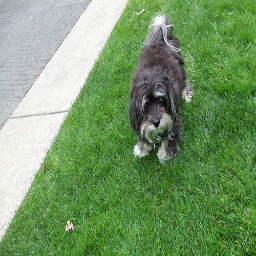

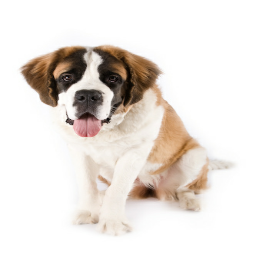

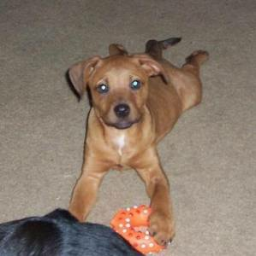

block1_conv1
(3, 64, 64)
block2_conv1
(3, 128, 128)
block3_conv1
(3, 256, 256)
block4_conv1
(3, 512, 512)
block5_conv1
(3, 512, 512)
block5_conv2
(3, 16, 16, 512)


In [8]:
# extract the inner-layers from the convolutional network
def gram_matrix(input_tensor):
    n_channels = input_tensor.get_shape().as_list()[-1]
    batch_size = input_tensor.get_shape().as_list()[0]
    unwrapped_out = tf.reshape(input_tensor, [batch_size, -1, n_channels])
    style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
    return style_matrix

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1) # new_tensor for same dimension of tensor
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0) # back to tensor within 0, 1
    return (batch - mean) / std


def extractor(images):
  images = images*255
  preprocessed_images = tf.keras.applications.vgg19.preprocess_input(images)
  outputs = classifier(preprocessed_images)
  for i in range(num_style_layers):
    outputs[i] = gram_matrix(outputs[i])
  return outputs


# preview of what we will do within the training loop:

#pick batch_size pictures
content_idxs =  np.random.randint(low=0, high=len(train_dataset)-1, size=3)
content_images = tf.stack([ train_dataset[i] for i in content_idxs])

# pick bach_size random styles
style_idxs = np.random.randint(low=1, high=num_styles, size=3)
style_images = tf.stack([ styles[i] for i in style_idxs])

# get the style and content
style_targets = extractor(style_images)
content_targets = extractor(content_images)

print(content_idxs)
print(style_idxs)
print(content_images.shape)
print(style_images.shape)

for image in content_images:
  display.display(tensor_to_image(image, squeeze = False))


#print the style layers
for name, shape in zip(style_layers + content_layers, style_targets):
  print(name)
  print(shape.shape)

In [16]:
#loss functions
style_weight=1.5e-13
content_weight=1e0
tvl_weight = 30

def total_loss(output, style_targets, content_targets, batch_size):

    style_loss = tf.add_n([tf.reduce_mean((output[i]-style_targets[i])**2) for i in range(num_style_layers)])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.reduce_mean((output[num_style_layers]-content_targets[num_style_layers])**2)
    content_loss *= content_weight / num_content_layers

    loss = ( style_loss + content_loss)/ batch_size
    return loss

# not used right now
def total_variation_loss(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

In [10]:
@tf.function
def train(batch_size, content_images, style_idxs, style_targets, content_targets):
  with tf.GradientTape() as tape:
      output = feed_forward_model(content_images, style_idxs)
      output_2 = extractor(output)
      loss = total_loss(output_2, style_targets, content_targets, batch_size)
  gradients = tape.gradient(loss, feed_forward_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, feed_forward_model.trainable_variables))
  return output

In [17]:
feed_forward_model = TransformerNet(num_styles)
feed_forward_model.trainable = True
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
batch_size = 18
batches = 3001

# the style indexis are fixed in order to make training faster, you can also select the style randomly
# using the same style sequence in each traning batch makes training much faster because you can expecute the same graph every time (@tf.funtion)
style_idxs = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
style_images = tf.stack([ tf.squeeze(styles[i]) for i in style_idxs])
style_targets = extractor(style_images)

show_style = 1
for batch in range(batches):
   # pick the pictures
   content_idxs =  np.random.randint(low=0, high=len(train_dataset), size=batch_size)
   content_images = tf.stack([ train_dataset[i] for i in content_idxs])
   # get content inner layers of the content images
   content_targets = extractor(content_images)

   output = train(batch_size, content_images, style_idxs, style_targets, content_targets)

   if batch%50 == 0:
    print("batch_number: %d, style: %d" % (batch, show_style%num_styles))
    combined_array = np.concatenate((tensor_to_image(content_images[show_style%num_styles], squeeze = False),
                                    tensor_to_image(styles[show_style%num_styles], squeeze = False),
                                    tensor_to_image(tf.clip_by_value(output[show_style%num_styles], clip_value_min=0.0, clip_value_max=1.0), squeeze = False)),
                                    axis = 1)
    combined_image = PIL.Image.fromarray(combined_array)
    display.display(combined_image)
    show_style += 1

Output hidden; open in https://colab.research.google.com to view.

In [43]:
output = feed_forward_model([styles[0]],[0])
feed_forward_model.save_weights('/content/drive/MyDrive/Colab_Notebooks/FF_neural_style_transter_weights')

In [86]:
#load the model:
trained_model = TransformerNet(num_styles)
trained_model.load_weights('/content/drive/MyDrive/Colab_Notebooks/FF_neural_style_transter_weights')
#trained_model.trainable = False

# the model can also combine styles (it can now only make a combination of two styles, but that is easy to change)
display.display(tensor_to_image(styles[3], squeeze = False))
for i in range(10):
  i = i/10
  output = trained_model([train_dataset[4]], [2], alpha = i, style_ids_2 = [3])
  display.display(tensor_to_image(tf.clip_by_value(output[0], clip_value_min=0.0, clip_value_max=1.0), squeeze = False))
display.display(tensor_to_image(styles[2], squeeze = False))

Output hidden; open in https://colab.research.google.com to view.

In [154]:
examples = [19, 10, 12, 15, 17, 30]



results = [tensor_to_image(styles[i], squeeze = False) for i in range(num_styles)]
combined_array = np.concatenate(([results[j] for j in range(num_styles)]), axis=1)
print(combined_array.shape)
combined_image = PIL.Image.fromarray(combined_array)
display.display(combined_image)

for example in examples:
   example = [train_dataset[example]]*6
   out = trained_model(example, [0, 1, 2, 3, 4, 5])

   out = tf.clip_by_value(out, clip_value_min=0.0, clip_value_max=1.0)
   results = [tensor_to_image(out[i], squeeze = False) for i in range(len(out))]
   combined_array = np.concatenate(([results[j] for j in range(len(out))]), axis=1)
   combined_image = PIL.Image.fromarray(combined_array)
   display.display(combined_image)



Output hidden; open in https://colab.research.google.com to view.